In [1]:
# For Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

# For image manipulation
import cv2
import imutils

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras import layers
from keras.models import Model

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Miscellaneous
import os
import shutil
import random
import pickle

# Suppress future, deprecation, and SettingWithCopy warnings
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

# make all columns in a df viewable and wider
pd.options.display.max_columns = None
pd.options.display.width = None
pd.set_option('max_colwidth', 400)

## Data
Pituitary, no tumor, meningioma, and glioma images (7023 total, ~80/20 train test split): https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

Other tumor images (1177 T1C+ images that I will use): https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c

In [2]:
train_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/'
test_dir = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/'

# Create a new directory named "other" in the train directory
new_train_dir = os.path.join(train_dir, 'other')
if not os.path.exists(new_train_dir):
    os.makedirs(new_train_dir)

# Create a new directory named "other" in the test directory
new_test_dir = os.path.join(test_dir, 'other')
if not os.path.exists(new_test_dir):
    os.makedirs(new_test_dir)

In [3]:
supplement_labels = ['Astrocitoma T1C+', 'Carcinoma T1C+', 'Ependimoma T1C+', 'Ganglioglioma T1C+',
                'Germinoma T1C+', 'Granuloma T1C+', 'Meduloblastoma T1C+', 'Neurocitoma T1C+',
                'Oligodendroglioma T1C+', 'Papiloma T1C+', 'Schwannoma T1C+', 'Tuberculoma T1C+']

supplement_path = '/Users/eli/Desktop/brain_tumor_CNN_classifier/data/supplement/'

# move 80% of images to the new "other" directory in train_dir and 20% to the new "other" directory in test_dir
for label in supplement_labels:
    folder_path = os.path.join(supplement_path, label)
    files = os.listdir(folder_path)
    random.shuffle(files)
    num_files = len(files)
    num_train_files = int(num_files * 0.8)
    train_files = files[:num_train_files]
    test_files = files[num_train_files:]
    files_moved = 0
    
    for filename in train_files:
        src_path = os.path.join(folder_path, filename)
        if os.path.isfile(src_path):
            dst_path = os.path.join(new_train_dir, filename)
            shutil.move(src_path, dst_path)
            files_moved += 1

    for filename in test_files:
        src_path = os.path.join(folder_path, filename)
        if os.path.isfile(src_path):
            dst_path = os.path.join(new_test_dir, filename)
            shutil.move(src_path, dst_path)
            files_moved += 1

In [4]:
labels = ['pituitary', 'notumor', 'meningioma', 'glioma', 'other']

X_train = []
y_train = []

for label in labels:
    for image in os.listdir(train_dir+label):
        X_train.append(train_dir+label+'/'+image)
        y_train.append(label)

In [5]:
X_test = []
y_test = []

for label in labels:
    for image in os.listdir(test_dir+label):
        X_test.append(test_dir+label+'/'+image)
        y_test.append(label)

In [6]:
X_train, y_train = shuffle(X_train, y_train)

In [7]:
tumor_train_df = pd.concat([pd.Series(X_train, name = 'paths'), 
                            pd.Series(y_train, name = 'label')], 
                            axis = 1)
tumor_train_df

,paths,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_1145.jpg,notumor
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_1078.jpg,notumor
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/meningioma/Tr-me_0808.jpg,meningioma
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/meningioma/Tr-me_0275.jpg,meningioma
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/other/109._big_gallery.jpeg,other
...,...,...
6638,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/meningioma/Tr-me_0623.jpg,meningioma
6639,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/notumor/Tr-no_1288.jpg,notumor
6640,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/other/26b06a9a1893927f854257f0167ca0_big_gallery.jpeg,other
6641,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Training/glioma/Tr-gl_0476.jpg,glioma


In [8]:
X_test, y_test = shuffle(X_test, y_test)

In [9]:
tumor_test_df = pd.concat([pd.Series(X_test, name = 'paths'), 
                            pd.Series(y_test, name = 'label')], 
                            axis = 1)
tumor_test_df

,paths,label
0,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/other/2b2ff71eb22a61bb9f7f141f5fd9f5_big_gallery.jpeg,other
1,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0016.jpg,glioma
2,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0034.jpg,notumor
3,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-glTr_0001.jpg,glioma
4,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0278.jpg,glioma
...,...,...
1552,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/pituitary/Te-pi_0136.jpg,pituitary
1553,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/meningioma/Te-me_0064.jpg,meningioma
1554,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/glioma/Te-gl_0056.jpg,glioma
1555,/Users/eli/Desktop/brain_tumor_CNN_classifier/data/Testing/notumor/Te-no_0056.jpg,notumor


## Exploratory Data Analysis

In [10]:
tumor_train_df.shape

(6643, 2)

In [11]:
tumor_train_df['label'].value_counts()

notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
other          931
Name: label, dtype: int64

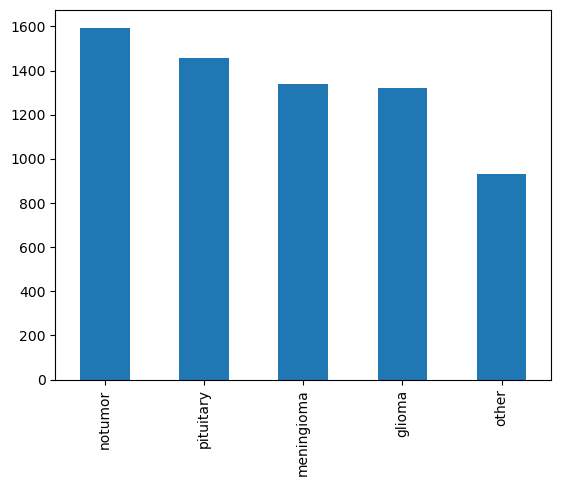

In [12]:
tumor_train_df['label'].value_counts().plot(kind = 'bar');

In [13]:
tumor_test_df['label'].value_counts()

notumor       405
meningioma    306
glioma        300
pituitary     300
other         246
Name: label, dtype: int64

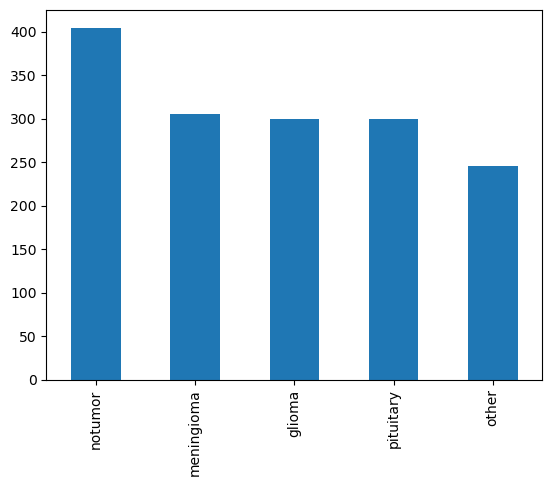

In [14]:
tumor_test_df['label'].value_counts().plot(kind = 'bar');

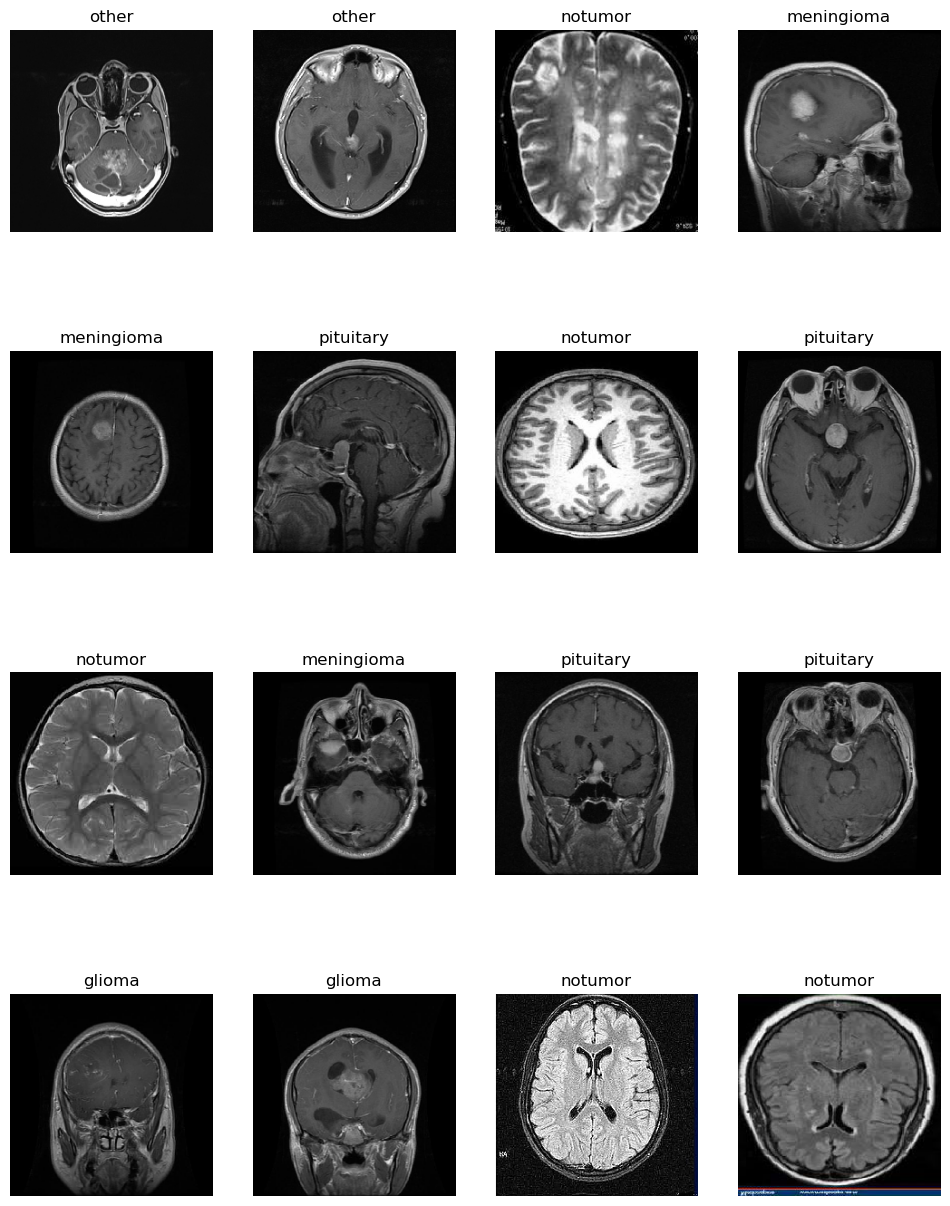

In [15]:
# with gratitude to MD Mushfirat Mohaimin for this code
# https://www.kaggle.com/code/mushfirat/brain-tumor-classification-accuracy-96

IMAGE_SIZE = (224, 224)

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays.
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=IMAGE_SIZE)
        images.append(image)
    return np.array(images, dtype=object)

images = open_images(X_train[50:67])
labels = y_train[50:67]
fig = plt.figure(figsize=(12, 16))
for x in range(1, 17):
    fig.add_subplot(4, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

## Baseline Model

In [16]:
train_datagen_baseline = ImageDataGenerator(rescale=1./255)
test_datagen_baseline = ImageDataGenerator(rescale=1./255)
batch_size = 32

train_generator_baseline = train_datagen_baseline.flow_from_dataframe(
        tumor_train_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990,
        shuffle = False)

test_generator_baseline = test_datagen_baseline.flow_from_dataframe(
        tumor_test_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990,
        shuffle = False)

Found 6642 validated image filenames belonging to 5 classes.
Found 1557 validated image filenames belonging to 5 classes.


/opt/homebrew/Caskroom/miniforge/base/envs/capstoneproj/lib/python3.8/site-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="paths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [17]:
cce = keras.losses.CategoricalCrossentropy()
opt = keras.optimizers.Adam()
callback = EarlyStopping(monitor='loss', patience=5)

In [18]:
model = Sequential()
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
base_model = model.fit(train_generator_baseline,
                       verbose = 1,
                       validation_data = test_generator_baseline, 
                       epochs=50,
                       callbacks = [callback])

2023-04-12 18:27:40.932752: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-12 18:27:40.932836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Epoch 1/50


2023-04-12 18:27:41.119453: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-12 18:27:41.285670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


207/208 [============================>.] - ETA: 0s - loss: 1.2390 - accuracy: 0.5855

2023-04-12 18:27:49.678727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 10s 48ms/step - loss: 1.2359 - accuracy: 0.5864 - val_loss: 0.8880 - val_accuracy: 0.6570
Epoch 2/50
208/208 [==============================] - 10s 47ms/step - loss: 0.7378 - accuracy: 0.7261 - val_loss: 0.8413 - val_accuracy: 0.7116
Epoch 3/50
208/208 [==============================] - 10s 47ms/step - loss: 0.6211 - accuracy: 0.7764 - val_loss: 0.7888 - val_accuracy: 0.7007
Epoch 4/50
208/208 [==============================] - 10s 47ms/step - loss: 0.5109 - accuracy: 0.8177 - val_loss: 0.7851 - val_accuracy: 0.7245
Epoch 5/50
208/208 [==============================] - 10s 47ms/step - loss: 0.4721 - accuracy: 0.8308 - val_loss: 0.6477 - val_accuracy: 0.7720
Epoch 6/50
208/208 [==============================] - 10s 47ms/step - loss: 0.4210 - accuracy: 0.8481 - val_loss: 0.5471 - val_accuracy: 0.8137
Epoch 7/50
208/208 [==============================] - 10s 47ms/step - loss: 0.3804 - accuracy: 0.8583 - val_loss: 0.5477 - val_accuracy: 0.8092
Epo

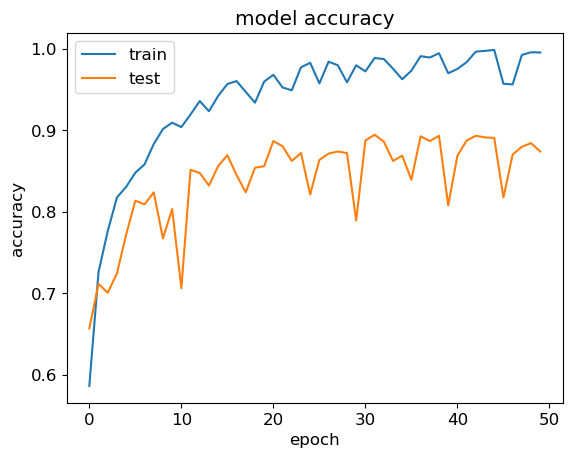

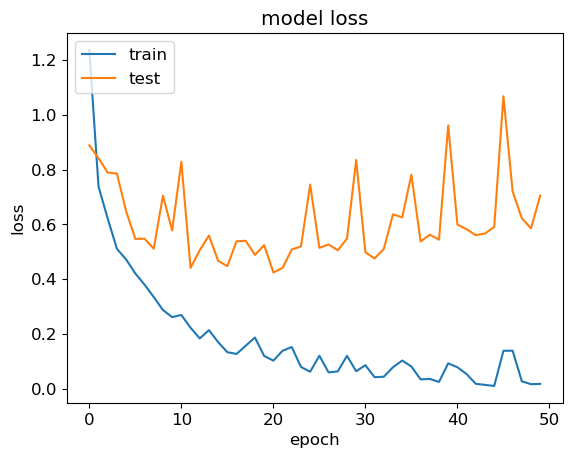

In [19]:
# summarize history for accuracy
plt.plot(base_model.history['accuracy'])
plt.plot(base_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(base_model.history['loss'])
plt.plot(base_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Data Augmentation and Second Model

In [20]:
train_datagen_aug = ImageDataGenerator(rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       brightness_range=[0.75, 1.25],
                                       rotation_range = 15)
test_datagen_aug = ImageDataGenerator(rescale=1./255)

train_generator_aug = train_datagen_aug.flow_from_dataframe(
        tumor_train_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990,
        shuffle = False)

test_generator_aug = test_datagen_aug.flow_from_dataframe(
        tumor_test_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode='grayscale',
        seed = 1990,
        shuffle = False)

Found 6642 validated image filenames belonging to 5 classes.
Found 1557 validated image filenames belonging to 5 classes.


/opt/homebrew/Caskroom/miniforge/base/envs/capstoneproj/lib/python3.8/site-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="paths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [42]:
model_conv = Sequential()
model_conv.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 1)))
model_conv.add(layers.MaxPooling2D((2, 2)))
model_conv.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv.add(layers.MaxPooling2D((2, 2)))
model_conv.add(layers.Flatten())
model_conv.add(layers.Dense(128, activation='relu'))
model_conv.add(layers.Dense(64, activation='relu'))
model_conv.add(layers.Dense(5, activation='softmax'))
model_conv.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
conv_model = model_conv.fit(train_generator_aug,
                       verbose = 1,
                       validation_data = test_generator_aug, 
                       epochs=50,
                       callbacks = [callback])

Epoch 1/50


2023-04-12 20:17:51.271016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 1.2084 - accuracy: 0.5238

2023-04-12 20:18:14.219781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 25s 119ms/step - loss: 1.2084 - accuracy: 0.5238 - val_loss: 0.9783 - val_accuracy: 0.6089
Epoch 2/50
208/208 [==============================] - 25s 119ms/step - loss: 0.8289 - accuracy: 0.6787 - val_loss: 0.8611 - val_accuracy: 0.6570
Epoch 3/50
208/208 [==============================] - 24s 117ms/step - loss: 0.7233 - accuracy: 0.7209 - val_loss: 0.7609 - val_accuracy: 0.6956
Epoch 4/50
208/208 [==============================] - 24s 116ms/step - loss: 0.6734 - accuracy: 0.7373 - val_loss: 0.7526 - val_accuracy: 0.6930
Epoch 5/50
208/208 [==============================] - 23s 110ms/step - loss: 0.6255 - accuracy: 0.7523 - val_loss: 0.6823 - val_accuracy: 0.7213
Epoch 6/50
208/208 [==============================] - 23s 109ms/step - loss: 0.6096 - accuracy: 0.7660 - val_loss: 0.6774 - val_accuracy: 0.7322
Epoch 7/50
208/208 [==============================] - 24s 115ms/step - loss: 0.5648 - accuracy: 0.7787 - val_loss: 0.6068 - val_accuracy: 0.7

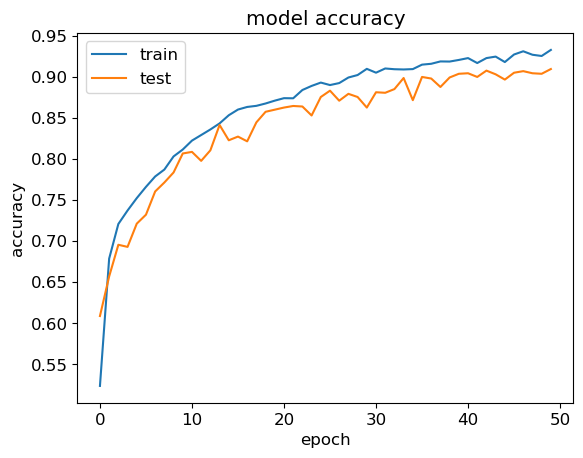

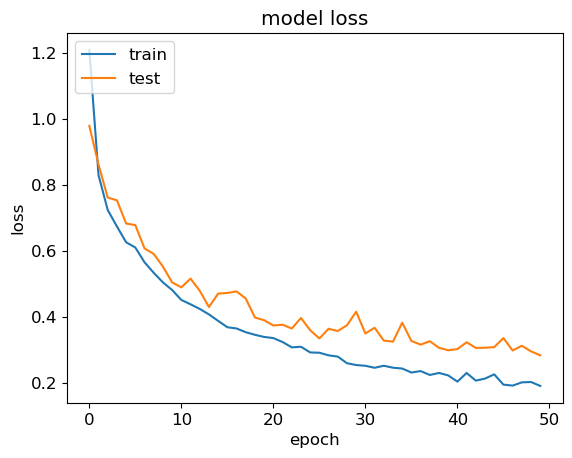

In [43]:
# summarize history for accuracy
plt.plot(conv_model.history['accuracy'])
plt.plot(conv_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(conv_model.history['loss'])
plt.plot(conv_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model 3: With Regularization

In [23]:
reg = l2(1e-2)

model_conv_drop = Sequential()
model_conv_drop.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 1), kernel_regularizer = reg))
model_conv_drop.add(BatchNormalization())
model_conv_drop.add(layers.MaxPooling2D((2, 2)))
model_conv_drop.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer = reg))
model_conv_drop.add(layers.MaxPooling2D((2, 2)))
model_conv_drop.add(layers.Flatten())
model_conv_drop.add(layers.Dense(128, activation='relu'))
model_conv_drop.add(Dropout(0.3))
model_conv_drop.add(layers.Dense(64, activation='relu'))
model_conv_drop.add(layers.Dense(32, activation='relu'))
model_conv_drop.add(layers.Dense(5, activation='softmax'))
model_conv_drop.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])
conv_drop_model = model_conv_drop.fit(train_generator_aug,
                       verbose = 1,
                       validation_data = test_generator_aug, 
                       epochs=50,
                       callbacks = [callback])

Epoch 1/50


2023-04-12 18:43:49.723076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 2.7028 - accuracy: 0.2355

2023-04-12 18:44:11.119768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 23s 110ms/step - loss: 2.7028 - accuracy: 0.2355 - val_loss: 1.8652 - val_accuracy: 0.2601
Epoch 2/50
208/208 [==============================] - 23s 110ms/step - loss: 1.4585 - accuracy: 0.4851 - val_loss: 1.8399 - val_accuracy: 0.2004
Epoch 3/50
208/208 [==============================] - 23s 110ms/step - loss: 1.0891 - accuracy: 0.6396 - val_loss: 1.1783 - val_accuracy: 0.6127
Epoch 4/50
208/208 [==============================] - 23s 110ms/step - loss: 0.8969 - accuracy: 0.7040 - val_loss: 0.8321 - val_accuracy: 0.7412
Epoch 5/50
208/208 [==============================] - 23s 110ms/step - loss: 0.7686 - accuracy: 0.7528 - val_loss: 0.7281 - val_accuracy: 0.7694
Epoch 6/50
208/208 [==============================] - 23s 110ms/step - loss: 0.6816 - accuracy: 0.7770 - val_loss: 0.7415 - val_accuracy: 0.7425
Epoch 7/50
208/208 [==============================] - 23s 110ms/step - loss: 0.6202 - accuracy: 0.7882 - val_loss: 0.5573 - val_accuracy: 0.8

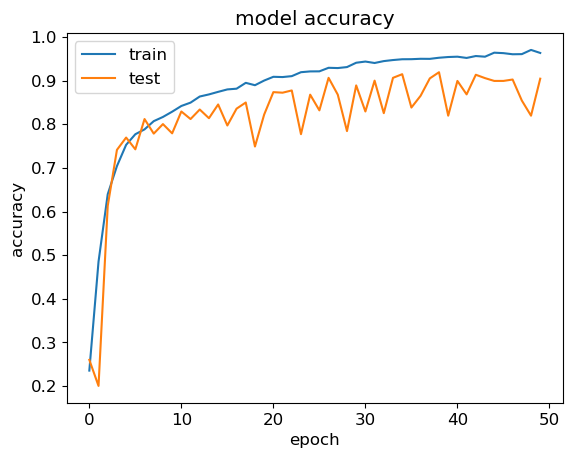

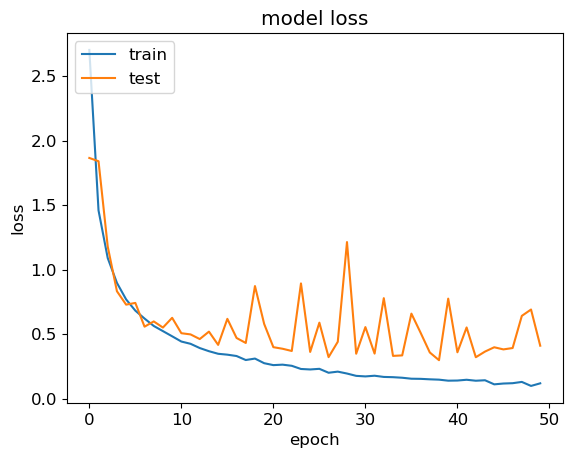

In [24]:
# summarize history for accuracy
plt.plot(conv_drop_model.history['accuracy'])
plt.plot(conv_drop_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(conv_drop_model.history['loss'])
plt.plot(conv_drop_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
# model_conv_drop.save('/Users/eli/Desktop/brain_tumor_CNN_classifier/final_model')

## Transfer Learning - VGG

In [26]:
train_generator_vgg = train_datagen_aug.flow_from_dataframe(
        tumor_train_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        seed = 1990,
        shuffle = False)

test_generator_vgg = test_datagen_aug.flow_from_dataframe(
        tumor_test_df,
        x_col = 'paths',
        y_col = 'label',
        target_size=IMAGE_SIZE,
        batch_size=batch_size,
        class_mode='categorical',
        seed = 1990,
        shuffle = False)

Found 6642 validated image filenames belonging to 5 classes.
Found 1557 validated image filenames belonging to 5 classes.


/opt/homebrew/Caskroom/miniforge/base/envs/capstoneproj/lib/python3.8/site-packages/keras/preprocessing/image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="paths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [27]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

output = vgg.layers[-1].output
output = layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
input_shape = vgg_model.output_shape[1]

In [28]:
vggmodel = Sequential()
vggmodel.add(vgg_model)
vggmodel.add(layers.Flatten())
vggmodel.add(Dense(512, activation='relu', input_dim=input_shape))
vggmodel.add(Dropout(0.3))
vggmodel.add(Dense(512, activation='relu'))
vggmodel.add(Dropout(0.3))
vggmodel.add(Dense(5, activation='softmax'))

vggmodel.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

vgg_model_feats = vggmodel.fit(train_generator_vgg,
                       verbose = 1,
                       validation_data = test_generator_vgg, 
                       epochs=30,
                       callbacks = [callback])

Epoch 1/30


2023-04-12 19:02:59.714663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 2.0214 - accuracy: 0.5397

2023-04-12 19:03:53.413947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 66s 315ms/step - loss: 2.0214 - accuracy: 0.5397 - val_loss: 0.8135 - val_accuracy: 0.6371
Epoch 2/30
208/208 [==============================] - 65s 314ms/step - loss: 0.7430 - accuracy: 0.6763 - val_loss: 0.6313 - val_accuracy: 0.7566
Epoch 3/30
208/208 [==============================] - 66s 315ms/step - loss: 0.6337 - accuracy: 0.7403 - val_loss: 0.6258 - val_accuracy: 0.7579
Epoch 4/30
208/208 [==============================] - 65s 313ms/step - loss: 0.5665 - accuracy: 0.7733 - val_loss: 0.5136 - val_accuracy: 0.7958
Epoch 5/30
208/208 [==============================] - 65s 314ms/step - loss: 0.5266 - accuracy: 0.7895 - val_loss: 0.4954 - val_accuracy: 0.8189
Epoch 6/30
208/208 [==============================] - 65s 313ms/step - loss: 0.4825 - accuracy: 0.8123 - val_loss: 0.4166 - val_accuracy: 0.8491
Epoch 7/30
208/208 [==============================] - 65s 314ms/step - loss: 0.4589 - accuracy: 0.8187 - val_loss: 0.4821 - val_accuracy: 0.8

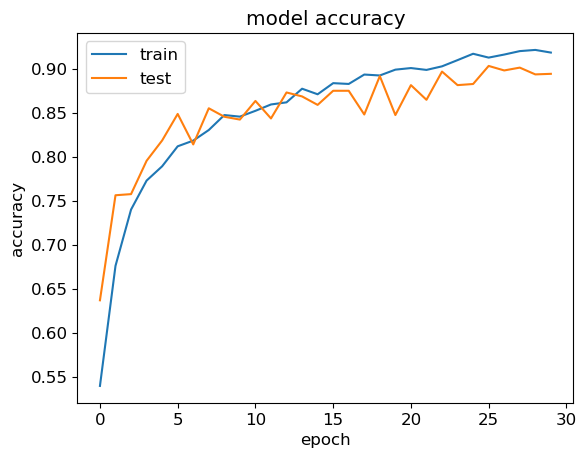

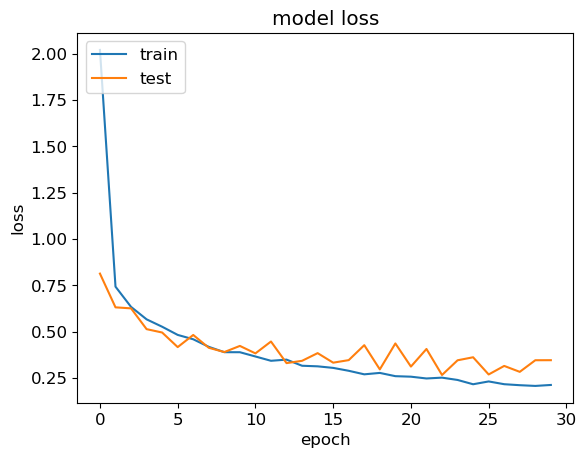

In [29]:
# summarize history for accuracy
plt.plot(vgg_model_feats.history['accuracy'])
plt.plot(vgg_model_feats.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vgg_model_feats.history['loss'])
plt.plot(vgg_model_feats.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### VGG With Fine-Tuning

In [30]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

output = vgg.layers[-1].output
output = layers.Flatten()(output)
vgg_model_finetune = Model(vgg.input, output)
    
input_shape = vgg_model_finetune.output_shape[1]

vgg_model_finetune.trainable = True
set_trainable = False
for layer in vgg_model_finetune.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [32]:
vgg_model_finetune.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [33]:
vggmodel_finetune = Sequential()
vggmodel_finetune.add(vgg_model_finetune)
vggmodel_finetune.add(layers.Flatten())
vggmodel_finetune.add(Dense(512, activation='relu', input_dim=input_shape))
vggmodel_finetune.add(Dropout(0.3))
vggmodel_finetune.add(Dense(512, activation='relu'))
vggmodel_finetune.add(Dropout(0.3))
vggmodel_finetune.add(Dense(5, activation='softmax'))

vggmodel_finetune.compile(optimizer=opt, loss=cce,  metrics=['accuracy'])

vgg_model_finetune = vggmodel_finetune.fit(train_generator_vgg,
                       verbose = 1,
                       validation_data = test_generator_vgg, 
                       epochs=30,
                       callbacks = [callback])

Epoch 1/30


2023-04-12 19:35:45.339255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - ETA: 0s - loss: 14.9350 - accuracy: 0.4231

2023-04-12 19:36:48.786164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


208/208 [==============================] - 76s 362ms/step - loss: 14.9350 - accuracy: 0.4231 - val_loss: 1.0404 - val_accuracy: 0.5973
Epoch 2/30
208/208 [==============================] - 75s 362ms/step - loss: 0.7408 - accuracy: 0.7192 - val_loss: 0.6526 - val_accuracy: 0.7630
Epoch 3/30
208/208 [==============================] - 76s 362ms/step - loss: 0.5404 - accuracy: 0.8023 - val_loss: 0.6280 - val_accuracy: 0.7611
Epoch 4/30
208/208 [==============================] - 76s 363ms/step - loss: 0.4453 - accuracy: 0.8443 - val_loss: 0.5307 - val_accuracy: 0.8080
Epoch 5/30
208/208 [==============================] - 75s 361ms/step - loss: 0.3860 - accuracy: 0.8640 - val_loss: 0.5002 - val_accuracy: 0.8150
Epoch 6/30
208/208 [==============================] - 75s 361ms/step - loss: 0.3671 - accuracy: 0.8686 - val_loss: 0.4524 - val_accuracy: 0.8227
Epoch 7/30
208/208 [==============================] - 76s 363ms/step - loss: 0.3272 - accuracy: 0.8806 - val_loss: 0.4481 - val_accuracy: 0.

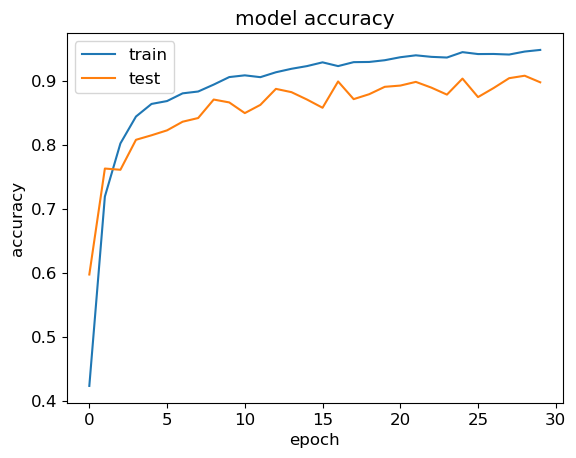

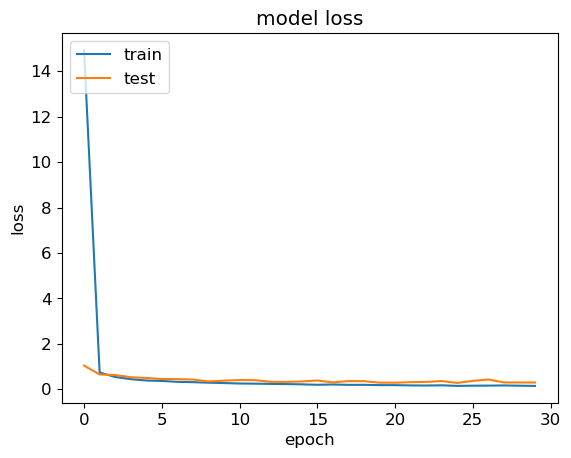

In [34]:
# summarize history for accuracy
plt.plot(vgg_model_finetune.history['accuracy'])
plt.plot(vgg_model_finetune.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vgg_model_finetune.history['loss'])
plt.plot(vgg_model_finetune.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
y_pred_conv = model_conv.predict(test_generator_aug, batch_size = batch_size)
y_pred_conv_drop = model_conv_drop.predict(test_generator_aug, batch_size = batch_size)
y_pred_vgg = vggmodel_finetune.predict(test_generator_vgg)

 5/49 [==>...........................] - ETA: 1s

2023-04-12 20:40:10.065535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 12s 247ms/step


In [46]:
y_pred_classes_conv = np.argmax(y_pred_conv, axis=1)
y_true_classes_conv = test_generator_aug.classes
y_pred_classes_conv_drop = np.argmax(y_pred_conv_drop, axis=1)
y_true_classes_conv_drop = test_generator_aug.classes
y_pred_classes_vgg = np.argmax(y_pred_vgg, axis=1)
y_true_classes_vgg = test_generator_vgg.classes

In [47]:
print(test_generator_aug.class_indices.keys())
print(test_generator_vgg.class_indices.keys())

dict_keys(['glioma', 'meningioma', 'notumor', 'other', 'pituitary'])
dict_keys(['glioma', 'meningioma', 'notumor', 'other', 'pituitary'])


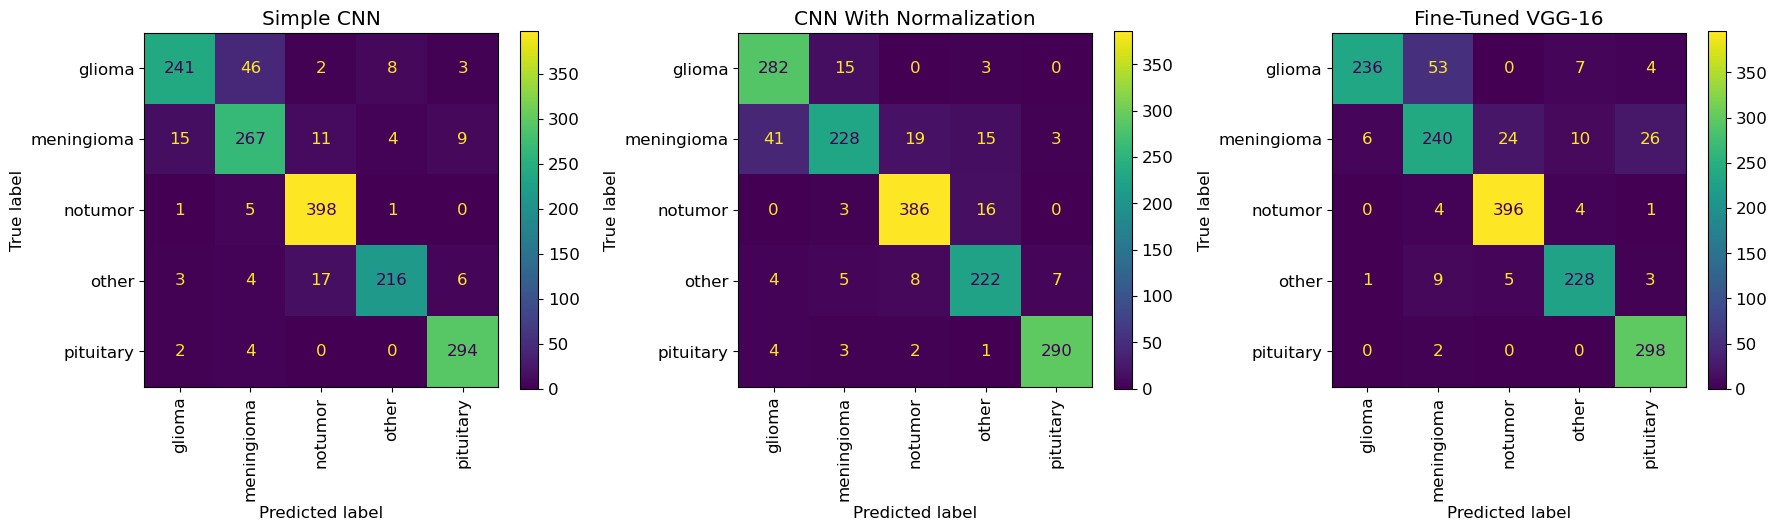

In [55]:
fig, axes = plt.subplots(figsize = (18, 5), ncols = 3)
report_labels = ['glioma', 'meningioma', 'notumor', 'other', 'pituitary']

ConfusionMatrixDisplay.from_predictions(y_true_classes_conv, y_pred_classes_conv, 
                                        display_labels = report_labels,
                                        xticks_rotation = 90,
                                        ax = axes[0])
ConfusionMatrixDisplay.from_predictions(y_true_classes_conv_drop, y_pred_classes_conv_drop, 
                                        display_labels = report_labels,
                                        xticks_rotation = 90,
                                        ax = axes[1])
ConfusionMatrixDisplay.from_predictions(y_true_classes_vgg, y_pred_classes_vgg, 
                                        display_labels = report_labels,
                                        xticks_rotation = 90,
                                        ax = axes[2])

axes[0].set_title('Simple CNN')
axes[1].set_title('CNN With Normalization')
axes[2].set_title('Fine-Tuned VGG-16')

plt.tight_layout()
plt.show();

In [39]:
results = model_conv_drop.evaluate(test_generator_aug, batch_size = batch_size)

49/49 [==============================] - 2s 37ms/step - loss: 0.4097 - accuracy: 0.9043


In [59]:
print(classification_report(test_generator_aug.classes, y_pred_classes_conv, target_names = report_labels))
print()
print(classification_report(test_generator_aug.classes, y_pred_classes_conv_drop, target_names = report_labels))
print()
print(classification_report(test_generator_vgg.classes, y_pred_classes_vgg, target_names = report_labels))

              precision    recall  f1-score   support

      glioma       0.92      0.80      0.86       300
  meningioma       0.82      0.87      0.84       306
     notumor       0.93      0.98      0.96       405
       other       0.94      0.88      0.91       246
   pituitary       0.94      0.98      0.96       300

    accuracy                           0.91      1557
   macro avg       0.91      0.90      0.91      1557
weighted avg       0.91      0.91      0.91      1557


              precision    recall  f1-score   support

      glioma       0.85      0.94      0.89       300
  meningioma       0.90      0.75      0.81       306
     notumor       0.93      0.95      0.94       405
       other       0.86      0.90      0.88       246
   pituitary       0.97      0.97      0.97       300

    accuracy                           0.90      1557
   macro avg       0.90      0.90      0.90      1557
weighted avg       0.91      0.90      0.90      1557


              precis

In [41]:
for name, value in zip(model_conv_drop.metrics_names, results):
    print(name, ': ', value)
print()

loss :  0.4097428321838379
accuracy :  0.9043031334877014

